In [11]:
#import matplotlib as matplot
#import seaborn
#import bokeh
#import keras
#import scipy
import pandas as pd
import numpy as np
import networkx as nx
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
import graphviz
from ncs1_import import ncs1_data
from ncsr_import import ncsr_data
import re
import copy
import pathpy as pp
import matplotlib.pyplot as plt
# For color mapping
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.lines as mlines
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import os
from tqdm import tqdm
# import block

# Pull ncsr data from file ncsr_import
ncsr = ncsr_data()
  # ncsr.ncsr holds all of the data from NCS 20240
  # https://www.icpsr.umich.edu/web/ICPSR/studies/20240
  # Alegria, Margarita, Jackson, James S. (James Sidney), Kessler, Ronald C., and Takeuchi, David. Collaborative Psychiatric Epidemiology Surveys (CPES), 2001-2003 [United States]. Ann Arbor, MI: Inter-university Consortium for Political and Social Research [distributor], 2016-03-23. https://doi.org/10.3886/ICPSR20240.v8
  # Key Functions:
    # ncsr.search_for_description looks for a descriotion of a column name in ncs1.dxdm or ncs1.survey
    # ncsr.get_variable_info queries icpsr for information like values, variable descriptions, and more
    # ncsr.get_value_from_string takes in a string that is a var name of dataframe in the ncsr description tree. Tree can be traversed using ncsr.root
  # Key Variables:
    # ncsr.ncsr 
    # ncsr.tree (Tree including descriptions of survey and dxdm columns)
    # ncsr.root (root used in traversing ncsr.tree)

# below code is used to cut out variables that have do do with onset age of symptoms
age_variable_subset = pd.DataFrame(columns = ['VarName', 'Description', 'Root_DF', 'Start', 'End', 'DataFrame', 'recursion_flag'])
#b = pd.DataFrame(columns = ['VarName', 'Description', 'Root_DF', 'Start', 'End', 'DataFrame', 'recursion_flag'])
#c = pd.DataFrame(columns = ['VarName', 'Description', 'Root_DF', 'Start', 'End', 'DataFrame', 'recursion_flag'])

for x in range(1, len(ncsr.root)):
    age_variable_subset = age_variable_subset.append(
        ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
            np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*.*", False)) & np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(^Age |^Age| age )+.*", False)) & np.logical_not(np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(^Remember|^Exact|^Age$|#|biological|when you were born|^Freq)+.*", False)))
            ]
    )
   ##  this checks each regex to see the variables gut out. pd.concat below checks the difference between DFs
    #b = b.append(
   #     ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #         np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #             'Description'].str.match(".*(first|1st|onset)+.*", False)) & np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #                 'Description'].str.match(".*(^Age |^Age| age | age|age | old|old | old |^DSM|^ICD)+.*", False))
   #         ]
   # )
   # c = c.append(
   #     ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #         np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(first|1st|onset)+.*", False))
   #         ]
   # )
   # pd.concat([,c]).drop_duplicates(keep=False).to_csv('out.csv')
#age_variable_subset = age_variable_subset.reset_index(drop=True)

#ncsr.ncs.to_csv('initialized_age_vars.csv')


ncsr_age_subset = ncsr.ncsr[list(age_variable_subset.iloc[:, 0])]
# Go in and pull out the variables for a subject that are valid and in a 
for y in range(0, len(ncsr_age_subset)):
    current_case = y
    case_age_vars = []
    for val, x in enumerate(age_variable_subset.iloc[:, 0]): 
            if ncsr_age_subset.loc[y, x] != ' ':
                if ncsr_age_subset.loc[y, x] != '.' and int(ncsr_age_subset.loc[y,x]) > 1 and int(ncsr_age_subset.loc[y,x]) < 100:
                    ncsr_age_subset.loc[y, x] = int(ncsr_age_subset.loc[y,x])
                else: 
                    ncsr_age_subset.loc[y, x] = -1
            else:
                ncsr_age_subset.loc[y,x] = -1

    #ncsr_age_subset_correct_vars.append(case_age_vars.append(age_variable_subset.loc[y, "CASEID"]))

#ncsr_age_subset


In [2]:
ncsr_age = pd.read_csv('age_subset.csv', index_col=0)

In [3]:
ncsr_age.insert(loc=0, column = "CASEID", value = ncsr_age.index + 1)

In [4]:
dsm_cases = []
dsm_names = []
for filename in os.listdir(r'C:\Users\galyn\Documents\GitHub\Seminar\dsm_out'):
    dsm = filename.split('.')[0]
    dsm_names.append(dsm)
    dsm_cases.append(pd.read_csv('dsm_out/' + filename))

In [35]:
for dsm_name in dsm_names:
    os.mkdir('individual_graphs/'+dsm_name)

In [30]:
dsm_names[0]

'DSM_ADD'

In [34]:
len(os.listdir(r'C:\Users\galyn\Documents\GitHub\seminar\individual_graphs\DSM_ALA'))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\galyn\\Documents\\GitHub\\seminar\\individual_graphs\\DSM_ALA'

In [42]:
for idx, cases_df in tqdm(enumerate(dsm_cases)):
    dsm_subset = ncsr_age[[x in cases_df.values for x in ncsr_age['CASEID']]].reset_index(drop=True)
    for case in range(len(dsm_subset)):
        case_number = dsm_subset.loc[case, 'CASEID'] 
        ordered_vals = []
        ordered_vars = []
        vals = []
        case_age_vars = []
        for symptom in dsm_subset:
            if symptom != "CASEID":
                if dsm_subset.loc[case, symptom] > 0:
                    vals.append(dsm_subset.loc[case, symptom])
                    case_age_vars.append(symptom)
        # initialize the ordered lists
        #order ints by age symptom occured
        for x in range(0, len(vals)):
            m = vals.index(min(vals))
            ordered_vals.append(vals[m])
            ordered_vars.append(case_age_vars[m])
            del vals[m]
            del case_age_vars[m]
        levels = []
        levels.append([])
        count = 0
        for idx1, val in enumerate(ordered_vals):
            if idx1 == 0:
                levels[count].append([ordered_vars[idx1], val])
            else: 
                if val == levels[count][0][1]:
                    levels[count].append([ordered_vars[idx1], val])
                else: 
                    levels.append([])
                    count += 1
                    levels[count].append([ordered_vars[idx1], val])

        G = nx.DiGraph()
        for x in range(0, len(ordered_vals)):
            G.add_node(ordered_vars[x], age = ordered_vals[x])

        #print(len(levels), case_number)
        for idx1, level in enumerate(levels): 
            if idx1+1 == len(levels): 
                continue
            for from_node in level: 
                for idx2, level in enumerate(levels[idx1:len(levels)]):
                    for to_node in level: 
                        G.add_edges_from([(from_node[0], to_node[0])])

        nx.write_gpickle(G, 'individual_graphs/' + dsm_names[idx] + '/graph_case_' + str(case_number)+'.pkl')
"""                 
        mult_flag = 0
        back_start = -1
        back_end = -1
        back_flag = 0
        start = 0
        for x in range(0, len(ordered_vars)-1):
            if ordered_vals[x] != ordered_vals[x+1]:
                if not mult_flag:
                    G.add_edges_from([(ordered_vars[x], ordered_vars[x+1])])
                    back_flag = 0
                else: 
                    for y in range(start, x+1):
                        G.add_edges_from([(ordered_vars[y], ordered_vars[x+1])])
                        back_flag = 1
                        back_end = x
                back_start = start
                start = x + 1
                mult_flag = 0
            elif ordered_vals[x] == ordered_vals[x+1]:
                mult_flag = 1
                if back_start<0:
                    continue
                if back_flag: 
                    for y in range(back_start, back_end + 1):
                        G.add_edges_from([(ordered_vars[y], ordered_vars[x+1])])
                else:
                    G.add_edges_from([(ordered_vars[back_start], ordered_vars[x+1])]) 
"""
      #  ncsr_age_graphs.append(G)


0it [00:00, ?it/s]DSM_ADD 365
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1it [00:04,  4.34s/it]0
0
DSM_AGO 231
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [40]:
dsm_subset = ncsr_age[[np.int64(x+1) in dsm_cases[0].values for x in ncsr_age.index]]
#mdd_subset = ncsr_age[(ncsr.ncsr.loc[:, diag2] == 1)]


#comorbid_subset_vals = [x for x in gad_subset.index if x in mdd_subset.index]



In [9]:
ncsr_age_edges_init = pd.DataFrame(0, columns = ncsr_age.iloc[:,0], index=ncsr_age.iloc[:,0])

In [10]:
edges = pd.DataFrame(0, columns = list(ncsr_age.columns)[1:], index=list(ncsr_age.columns)[1:])
average_onset_age_init = {x: 0 for x in edges}

In [11]:
average_onset_age_init = {}
for x in ncsr_age_edges_init:
    average_onset_age_init[x] = 0

In [12]:
ncsr_age_edges = ncsr_age_edges_init.copy(deep=True)
average_onset = copy.deepcopy(average_onset_age_init)
onset_count = copy.deepcopy(average_onset_age_init)

In [13]:
ncsr_age_graphs = []
for case in range(len(comorbid_subset)):
    case_number = ncsr_age_subset.iloc[case, 0]
    ordered_vals =[]
    ordered_vars = []
    vals = []
    case_age_vars = []
    for symptom in ncsr_age_subset:
        if symptom != "CASEID":
            if ncsr_age_subset.loc[case, symptom] > 0:
                vals.append(ncsr_age_subset.loc[case, symptom])
                case_age_vars.append(symptom)
    # initialize the ordered lists
    #order ints by age symptom occured
    for x in range(0, len(vals)):
        m = vals.index(min(vals))
        ordered_vals.append(vals[m])
        ordered_vars.append(case_age_vars[m])
        del vals[m]
        del case_age_vars[m]

    G = nx.DiGraph()
    for x in range(0, len(ordered_vals)):
        G.add_node(ordered_vars[x], age = ordered_vals[x])
    mult_flag = 0
    back_start = -1
    back_end = -1
    back_flag = 0
    start = 0
    for x in range(0, len(ordered_vars)-1):
        if ordered_vals[x] != ordered_vals[x+1]:
            if not mult_flag:
                G.add_edges_from([(ordered_vars[x], ordered_vars[x+1])])
                back_flag = 0
            else: 
                for y in range(start, x+1):
                    G.add_edges_from([(ordered_vars[y], ordered_vars[x+1])])
                    back_flag = 1
                    back_end = x
            back_start = start
            start = x + 1
            mult_flag = 0
        elif ordered_vals[x] == ordered_vals[x+1]:
            mult_flag = 1
            if back_start<0:
                continue
            if back_flag: 
                for y in range(back_start, back_end + 1):
                    G.add_edges_from([(ordered_vars[y], ordered_vars[x+1])])
            else:
                G.add_edges_from([(ordered_vars[back_start], ordered_vars[x+1])]) 

    ncsr_age_graphs.append(G)
"""
for x in add_graphs: 
    node_age_added = []
    for from_node in age_variable_subset.iloc[:,0]:
        for to_node in age_variable_subset.iloc[:,0]:
            if x.has_edge(from_node, to_node):
                if from_node not in node_age_added: 
                    onset_count[from_node] += 1
                    average_onset[from_node] += x.nodes[from_node]['age']
                    node_age_added.append(from_node)
                if to_node not in node_age_added:
                    onset_count[to_node] += 1
                    average_onset[to_node] += x.nodes[to_node]['age']
                    node_age_added.append(to_node)
                
                ncsr_age_edges.loc[from_node, to_node] += 1
"""

NameError: name 'comorbid_subset' is not defined

In [162]:
for var, val in onset_count.items(): 
    if val > 0: 
        average_onset[var] = average_onset[var]/val

In [163]:
for x in range(len(ncsr_age_edges)):
    for y in range(len(ncsr_age_edges)):
        ncsr_age_edges.iloc[x, y] = ncsr_age_edges.iloc[x, y]/len(ncsr_age_subset)


In [164]:
all_matrix = pd.read_csv('all_adjacency_matrix.csv', index_col=0)

In [169]:
num = 0
main_graph = nx.DiGraph()
added_nodes = []
count = 0
for x in add_edges:
    for y in add_edges:
        if add_edges.loc[x, y] > .1 and all_matrix.loc[x,y]<.1: 
            count+=1
            if x not in added_nodes:
                main_graph.add_node(x)
                added_nodes.append(x)
            if y not in added_nodes:
                main_graph.add_node(y)
                added_nodes.append(y)
            main_graph.add_edges_from([(x, y)], weight = add_edges.loc[x, y]*50)
print(added_nodes)

['SU1', 'SU87B', 'SU2A', 'EM1', 'MR1_2', 'DM_EM1', 'SU87A', 'CN3', 'SU45A', 'PR2', 'PR4A', 'PR4C', 'MR19', 'DM_MR19']


In [171]:
ncsr.get_value_from_string(ncsr.root.iloc[0,0])

,VarName,Description,Root_DF,Start,End,DataFrame,recursion_flag
0,SC7,Smoker,Screening,0,0,ncsr,0
1,SC8_1,Physical health rating,Screening,1,1,ncsr,0
2,SC8_2,Mental health rating,Screening,2,2,ncsr,0
3,SC9A,General health status compared to year ago,Screening,3,3,ncsr,0
4,SC9B,General health how much better/worse than year...,Screening,4,4,ncsr,0
...,...,...,...,...,...,...,...
148,SC10_8G201,Physical illness:1st mention,Screening,148,148,ncsr,0
149,SC10_8G202,Physical illness:2nd mention,Screening,149,149,ncsr,0
150,SC10_8G203,Physical illness:3rd mention,Screening,150,150,ncsr,0
151,SC10_8G204,Physical illness:4th mention,Screening,151,151,ncsr,0


vals = list(ncsr.ncsr.loc[current_case, case_age_vars]) # get all of the values for the case_age_vars
vals = [int(i) for i in vals] # make sure that the vals are ints

ordered_vals =[]
ordered_vars = []
  # initialize the ordered lists

#order ints by age symptom occured
for x in range(0, len(vals)):
    m = vals.index(min(vals))
    ordered_vals.append(vals[m])
    ordered_vars.append(case_age_vars[m])
    del vals[m]
    del case_age_vars[m]

G = nx.DiGraph()
for x in range(0, len(ordered_vals)):
    G.add_node(ordered_vars[x], age = ordered_vals[x])
flag = 1
back_start = -1
back_flag = 0
start = -1
for x in range(1, len(ordered_vars)):
    print(ordered_vars[x], flag, start, back_flag,  back_start)
    print(ordered_vals[x], ordered_vals[x-1])
    if ordered_vals[x-1] != ordered_vals[x] and flag == 1:
        if back_flag: 
            for y in range(back_start, x):
                #print("G.add_edges_from([(ordered_vars["+str(y)+"], ordered_vars["+str(x)+"])])")
                G.add_edges_from([(ordered_vars[y], ordered_vars[x])])
        else: 
            G.add_edges_from([(ordered_vars[x-1], ordered_vars[x])])
        back_start=start
        start = x
        back_flag = 0
        flag = 1
    elif x + 1 == len(ordered_vals) and flag == 0:
        if back_flag:
            for y in range(back_start, start):
                for z in range(start, x):
                    G.add_edges_from([(ordered_vars[y], ordered_vars[z]), (ordered_vars[z], ordered_vars[x])])
        else:
            for y in range(start, x):
                G.add_edges_from([(ordered_vars[start], ordered_vars[y]), (ordered_vars[y], ordered_vars[x])])
        start = x
    elif x + 1 == len(ordered_vals) and flag == 1:
        if back_flag: 
            for y in range(back_start, x):
                G.add_edges_from([(ordered_vars[y], ordered_vars[x])])
        else: 
            G.add_edges_from([(ordered_vars[x-1], ordered_vars[x])])
        start =x
    elif ordered_vals[x-1] != ordered_vals[x] and start == -1: 
        start = x
        for y in range(0, x):
           G.add_edges_from([(ordered_vars[y], ordered_vars[x])])
        back_flag = 0
        back_start = 0
    elif ordered_vals[x-1] != ordered_vals[x] and flag == 0: 
        if back_flag:
            for y in range(back_start, start):
                for z in range(start, x):
                    G.add_edges_from([(ordered_vars[y], ordered_vars[z]), (ordered_vars[z], ordered_vars[x])])
        else:
            for y in range(start, x):
                G.add_edges_from([(ordered_vars[start], ordered_vars[y]), (ordered_vars[y], ordered_vars[x])])
        flag = 1
        back_start = start
        start = x
        back_flag = 1
    else:
        flag = 0
        

G = copy.deepcopy(main_graph)
for x in range(0, len(ordered_vals)):
    G.add_node(ordered_vars[x], age = ordered_vals[x])
mult_flag = 0
back_start = -1
back_end = -1
back_flag = 0
start = 0
for x in range(0, len(ordered_vars)-1):
    if ordered_vals[x] != ordered_vals[x+1]:
        if not mult_flag:
            G.add_edges_from([(ordered_vars[x], ordered_vars[x+1])])
            back_flag = 0
        else: 
            for y in range(start, x+1):
                G.add_edges_from([(ordered_vars[y], ordered_vars[x+1])])
                back_flag = 1
                back_end = x
        back_start = start
        start = x + 1
        mult_flag = 0
    elif ordered_vals[x] == ordered_vals[x+1]:
        mult_flag = 1
        if back_start<0:
            continue
        if back_flag: 
            for y in range(back_start, back_end + 1):
                G.add_edges_from([(ordered_vars[y], ordered_vars[x+1])])
        else:
            G.add_edges_from([(ordered_vars[back_start], ordered_vars[x+1])]) 
    

add_graphs.append(G)


import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
#import pygraphviz
#pos = nx.drawing.nx_agraph.graphviz_layout(G)
#pos = nx.kamada_kawai_layout(G, pos = nx.spring_layout(G, k=3, iterations=10, dim=2, seed = 3))
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
G = nx.read_gpickle('graph.pkl')
pos = graphviz_layout(G, 'dot')
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=1,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])



node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        #reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=10,
            title='Age',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])


for x in G.nodes(data = True):
    node_trace['marker']['color']+=tuple([x[1]['age']])
    node_info = x[0] +' Age: '+str(x[1]['age'])
    node_trace['text']+=tuple([node_info])


fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network for CASEID 445',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)


'\n#, node_size= 4000, vmax = max(level_vals) + .1, vmin = min(level_vals) - .1, with_labels = True, edge_color = list(nx.get_edge_attributes(G,\'weight\').values()), arrowsize= 20, width = 3, edge_cmap =  plt.get_cmap(\'Greens\'), edge_vmin = 0, connectionstyle="arc3,rad=.3")\nax = []\n#for x in level_vals:\n    #ax.append(.Line2D([], [], color=scalarMap.to_rgba(level_set.index(x) + 1), label = "Category: " + x, marker="o", markersize=20))\n#plt.legend(prop={\'size\': 20}, handles = ax)\nnx.draw_networkx_nodes(G, pos, node_color = \'white\', node_size = 2500)\nnodes = nx.draw_networkx_nodes(G, pos, node_color = level_vals, vmax = max(level_vals) + .1, vmin = max(level_vals) - .1, node_size = 0)\nedges = nx.draw_networkx_edges(G, pos, edge_color = [x/50 for x in nx.get_edge_attributes(G,\'wt\').values()], edge_cmap =  plt.get_cmap(\'Greens\'), arrows=False, edge_vmin=0)\nedge_cbar = plt.colorbar(edges, orientation=\'horizontal\', pad = 0.03)\nnode_cbar = plt.colorbar(nodes, orientation

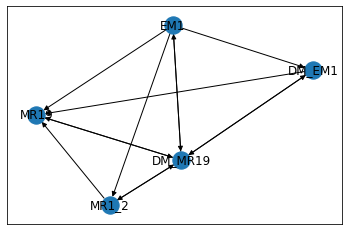

In [9]:
#G = nx.read_gpickle('graph.pkl')
#G = main_graph
#pos = nx.kamada_kawai_layout(G, pos = nx.spring_layout(G, k = .15, iterations = 100, seed = 10020) )#

pos = graphviz_layout(G, prog="dot")
"""
#pos = nx.spring_layout(G, k = 4, iterations = 100, seed = 10020)
levels = []
vals = {}
for x in list(G.nodes):
    for x in G.nodes:
        vals[x] = len(dsm_subset[dsm_subset[x]!= -1])/len(dsm_subset.iloc[:, 1])

level_vals = list(vals.values())
col = cm = plt.get_cmap('Blues')
cNorm  = colors.Normalize(vmin=min(level_vals)-.1, vmax=max(level_vals)+.1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=col)
plt.set_cmap(col)
f = plt.figure(3, figsize=(20,15))
"""
nx.draw_networkx(G, pos)
"""
#, node_size= 4000, vmax = max(level_vals) + .1, vmin = min(level_vals) - .1, with_labels = True, edge_color = list(nx.get_edge_attributes(G,'weight').values()), arrowsize= 20, width = 3, edge_cmap =  plt.get_cmap('Greens'), edge_vmin = 0, connectionstyle="arc3,rad=.3")
ax = []
#for x in level_vals:
    #ax.append(.Line2D([], [], color=scalarMap.to_rgba(level_set.index(x) + 1), label = "Category: " + x, marker="o", markersize=20))
#plt.legend(prop={'size': 20}, handles = ax)
nx.draw_networkx_nodes(G, pos, node_color = 'white', node_size = 2500)
nodes = nx.draw_networkx_nodes(G, pos, node_color = level_vals, vmax = max(level_vals) + .1, vmin = max(level_vals) - .1, node_size = 0)
edges = nx.draw_networkx_edges(G, pos, edge_color = [x/50 for x in nx.get_edge_attributes(G,'wt').values()], edge_cmap =  plt.get_cmap('Greens'), arrows=False, edge_vmin=0)
edge_cbar = plt.colorbar(edges, orientation='horizontal', pad = 0.03)
node_cbar = plt.colorbar(nodes, orientation='horizontal', pad = 0)
edge_cbar.set_label("Edge Prevalence", size = 25)
node_cbar.set_label("Node Prevalence", size = 25)
plt.title("MDD/GAD Comorbid Network", fontsize = 40)#diag1 + " - " + diag2, fontsize = 40)
bbox_props = dict(boxstyle= "round, pad =.4", ec = 'black', fc = 'white')
g = r"$\bf{" + "Node" + "}$" + " " +  r"$\bf{" + "Descriptions:" + "}$" + "\n"
for x in list(G.nodes):
 g += x + ": " + ncsr.search_for_description(x)[1] + "\n" 
t = plt.annotate(g, xy = (1.01,0.2), xycoords='axes fraction', bbox = bbox_props, size = 20)
plt.savefig('plots/case_mad_gad.jpg', bbox_inches = 'tight')
"""

#G = nx.read_gpickle('graph.pkl')
G = main_graph
#pos = nx.kamada_kawai_layout(G, pos = nx.spring_layout(G, k = .15, iterations = 100, seed = 10020) )#

pos = graphviz_layout(G, prog="twopi")
#pos = nx.spring_layout(G, k = 4, iterations = 100, seed = 10020)
levels = []
vals = {}
for x in list(G.nodes):
    for x in G.nodes:
        vals[x] = len(comorbid_subset[comorbid_subset[x]!= -1])/len(comorbid_subset.iloc[:, 1])

level_vals = list(vals.values())
col = cm = plt.get_cmap('Blues')
cNorm  = colors.Normalize(vmin=min(level_vals)-.1, vmax=max(level_vals)+.1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=col)
plt.set_cmap(col)
f = plt.figure(3, figsize=(20,15))
nx.draw_networkx(G, pos, node_color=level_vals, node_size= 4000, vmax = max(level_vals) + .1, vmin = min(level_vals) - .1, with_labels = True, edge_color = list(nx.get_edge_attributes(G,'weight').values()), arrowsize= 20, width = 3, edge_cmap =  plt.get_cmap('Greens'), edge_vmin = 0, connectionstyle="arc3,rad=.3")
ax = []
#for x in level_vals:
    #ax.append(.Line2D([], [], color=scalarMap.to_rgba(level_set.index(x) + 1), label = "Category: " + x, marker="o", markersize=20))
#plt.legend(prop={'size': 20}, handles = ax)
nx.draw_networkx_nodes(G, pos, node_color = 'white', node_size = 2500)
nodes = nx.draw_networkx_nodes(G, pos, node_color = level_vals, vmax = max(level_vals) + .1, vmin = max(level_vals) - .1, node_size = 0)
edges = nx.draw_networkx_edges(G, pos, edge_color = [x/50 for x in nx.get_edge_attributes(G,'wt').values()], edge_cmap =  plt.get_cmap('Greens'), arrows=False, edge_vmin=0)
edge_cbar = plt.colorbar(edges, orientation='horizontal', pad = 0.03)
node_cbar = plt.colorbar(nodes, orientation='horizontal', pad = 0)
edge_cbar.set_label("Edge Prevalence", size = 25)
node_cbar.set_label("Node Prevalence", size = 25)
plt.title(diag1 + " - " + diag2, fontsize = 40)
bbox_props = dict(boxstyle= "round, pad =.4", ec = 'black', fc = 'white')
g = r"$\bf{" + "Node" + "}$" + " " +  r"$\bf{" + "Descriptions:" + "}$" + "\n"
for x in list(G.nodes):
 g += x + ": " + ncsr.search_for_description(x)[1] + "\n" 
t = plt.annotate(g, xy = (1.01,0.2), xycoords='axes fraction', bbox = bbox_props, size = 20)
plt.savefig('plots/case_' + diag1 + "_" + diag2 + '.jpg', bbox_inches = 'tight')

In [166]:
ncsr.ncsr["CH30_1A"]

0       4
1        
2       4
3       4
4        
       ..
9277    4
9278     
9279     
9280    4
9281    4
Name: CH30_1A, Length: 9282, dtype: object

In [8]:
levels

[[['EM1', 12], ['DM_EM1', 12]],
 [['MR1_2', 17]],
 [['MR19', 24], ['DM_MR19', 24]]]